# CSE 158 Assignment 2


# Import libs

In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import string
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
from IPython.display import HTML, display
from sklearn.ensemble import RandomForestClassifier

# Steam Dataset: Load Datasets

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

print("Loading Game Metadata...")
games_metadata = []
for line in parse('/Users/nomin1/Downloads/data/steam_games.json.gz'):
    if 'id' in line:
        games_metadata.append(line)
steam_games = pd.DataFrame(games_metadata)
print(f"Successfully Loaded {len(steam_games)} game metadata.")

print("Loading User Items (Ownership & Playtime)...")
data_items = []
for line in parse('/Users/nomin1/Downloads/data/australian_users_items.json.gz'):
    data_items.append(line)
    
australian_users_items = pd.DataFrame(data_items)
print(f"Successfully Loaded {len(australian_users_items)} users.")

Loading Game Metadata...
Successfully Loaded 32133 game metadata.
Loading User Items (Ownership & Playtime)...
Successfully Loaded 88310 users.


In [3]:
print(f"Shape: {steam_games.shape}")
steam_games.head()

Shape: (32133, 16)


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [4]:
print(f"Shape: {australian_users_items.shape}")
australian_users_items.head()

Shape: (88310, 5)


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


# Exploratory Data Analysis

In [5]:
#  check data types
steam_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [6]:
#  check data types
australian_users_items.dtypes

user_id        object
items_count     int64
steam_id       object
user_url       object
items          object
dtype: object

In [7]:
# check missing values
steam_games.isnull().mean().sort_values(ascending=False)

discount_price    0.993029
metascore         0.916721
publisher         0.250552
sentiment         0.223477
developer         0.102636
genres            0.102138
release_date      0.064295
title             0.063766
price             0.042853
specs             0.020820
tags              0.005042
app_name          0.000031
url               0.000000
reviews_url       0.000000
early_access      0.000000
id                0.000000
dtype: float64

In [8]:
# check missing values
australian_users_items.isnull().mean().sort_values(ascending=False)

user_id        0.0
items_count    0.0
steam_id       0.0
user_url       0.0
items          0.0
dtype: float64

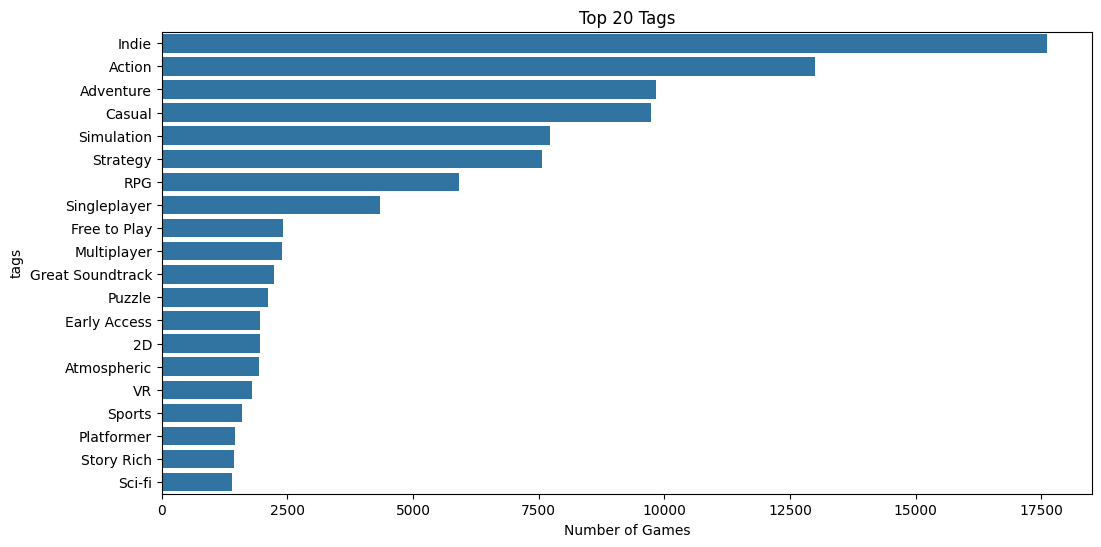

In [9]:
# Genre Analysis - 'explode' the genres column (because games have multiple genres)
df_exploded = steam_games.explode('tags')

# Count how many games exist per genre
plt.figure(figsize=(12, 6))
genre_counts = df_exploded['tags'].value_counts().head(20)
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Top 20 Tags')
plt.xlabel('Number of Games')
plt.show()

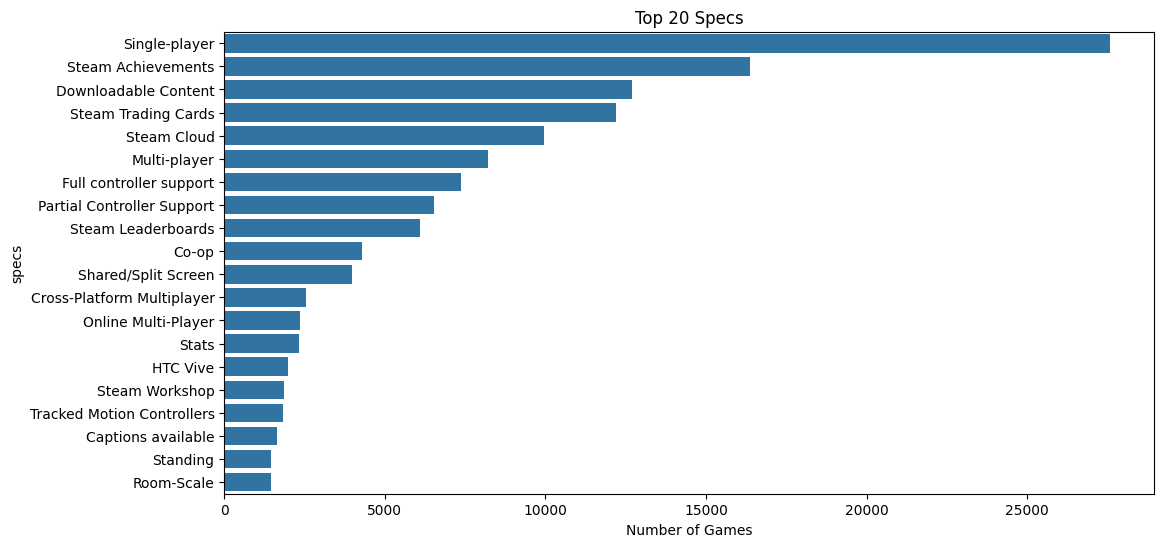

In [10]:
# Genre Analysis - 'explode' the genres column (because games have multiple genres)
df_exploded_s = steam_games.explode('specs')

# Count how many games exist per genre
plt.figure(figsize=(12, 6))
genre_counts = df_exploded_s['specs'].value_counts().head(20)
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Top 20 Specs')
plt.xlabel('Number of Games')
plt.show()

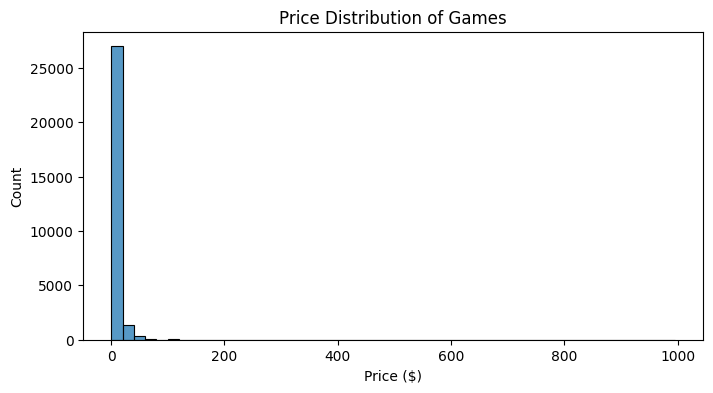

In [11]:
#  Price Distribution
prices = pd.to_numeric(steam_games['price'], errors='coerce')
plt.figure(figsize=(8,4))
sns.histplot(prices, bins=50)
plt.title("Price Distribution of Games")
plt.xlabel("Price ($)")
plt.show()

In [12]:
# Explode items column to get individual game entries per user
u = australian_users_items.explode('items').reset_index(drop=True)
i = pd.json_normalize(u['items'])
i

,item_id,item_name,playtime_forever,playtime_2weeks
0,10,Counter-Strike,6.0,0.0
1,20,Team Fortress Classic,0.0,0.0
2,30,Day of Defeat,7.0,0.0
3,40,Deathmatch Classic,0.0,0.0
4,50,Half-Life: Opposing Force,0.0,0.0
...,...,...,...,...
5170010,373330,All Is Dust,0.0,0.0
5170011,388490,One Way To Die: Steam Edition,3.0,3.0
5170012,521570,You Have 10 Seconds 2,4.0,4.0
5170013,519140,Minds Eyes,3.0,3.0


In [13]:
# Playtime Statistics
i['playtime_forever'].describe().round(0).astype(int)

count    5153209
mean         991
std         5418
min            0
25%            0
50%           34
75%          355
max       642773
Name: playtime_forever, dtype: int64

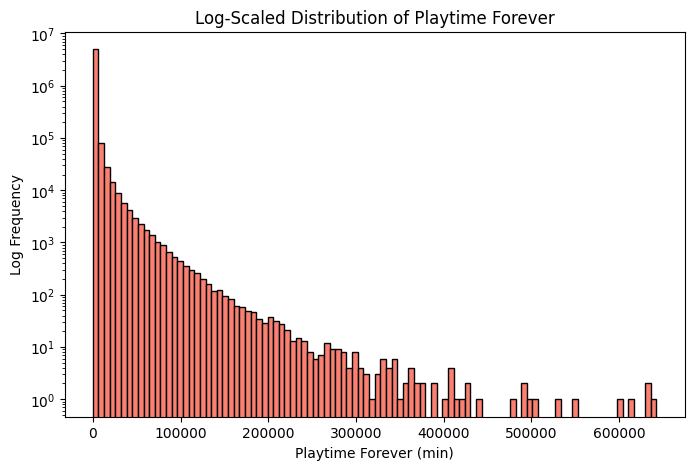

In [14]:
# Playtime Distribution (Log-Scaled)
# log scaled due the highly skewed distribution
plt.figure(figsize=(8,5))
plt.hist(i['playtime_forever'], bins=100, color='salmon', edgecolor='black', log=True)
plt.xlabel("Playtime Forever (min)")
plt.ylabel("Log Frequency")
plt.title("Log-Scaled Distribution of Playtime Forever")
plt.show()

In [15]:
# Merge game metadata with user items on item_id and id
i['item_id'] = i['item_id'].astype(str)
steam_games['id'] = steam_games['id'].astype(str)

df_merged = i.merge(
    steam_games[['id','price','discount_price','tags','sentiment','early_access', 'release_date']],
    left_on='item_id', right_on='id',
    how='left'
)
df_merged.head()

,item_id,item_name,playtime_forever,playtime_2weeks,id,price,discount_price,tags,sentiment,early_access,release_date
0,10,Counter-Strike,6.0,0.0,10,9.99,NaN,"[Action, FPS, Multiplayer, Shooter, Classic, T...",Overwhelmingly Positive,False,2000-11-01
1,20,Team Fortress Classic,0.0,0.0,20,4.99,NaN,"[Action, FPS, Multiplayer, Classic, Shooter, C...",Very Positive,False,1999-04-01
2,30,Day of Defeat,7.0,0.0,30,4.99,NaN,"[FPS, World War II, Multiplayer, Action, Shoot...",Very Positive,False,2003-05-01
3,40,Deathmatch Classic,0.0,0.0,40,4.99,NaN,"[Action, FPS, Multiplayer, Classic, Shooter, F...",Very Positive,False,2001-06-01
4,50,Half-Life: Opposing Force,0.0,0.0,50,4.99,NaN,"[FPS, Action, Sci-fi, Singleplayer, Classic, S...",Very Positive,False,1999-11-01


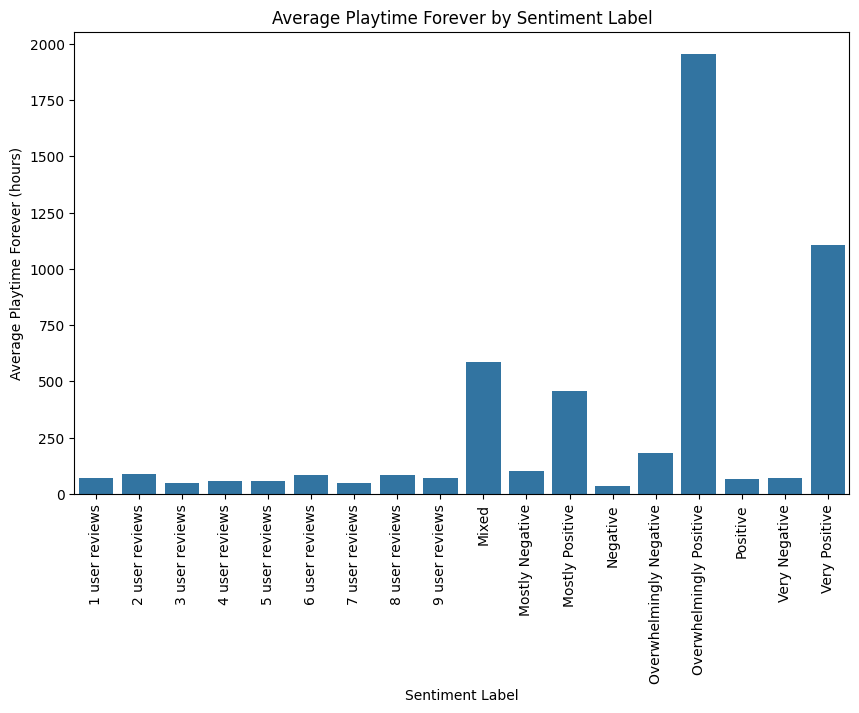

In [16]:
# Group by sentiment and calculate average playtime
avg_playtime = df_merged.groupby('sentiment')['playtime_forever'].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x='sentiment',
    y='playtime_forever',
    data=avg_playtime
)
plt.xlabel("Sentiment Label")
plt.ylabel("Average Playtime Forever (hours)")
plt.title("Average Playtime Forever by Sentiment Label")
plt.xticks(rotation=90)
plt.show()

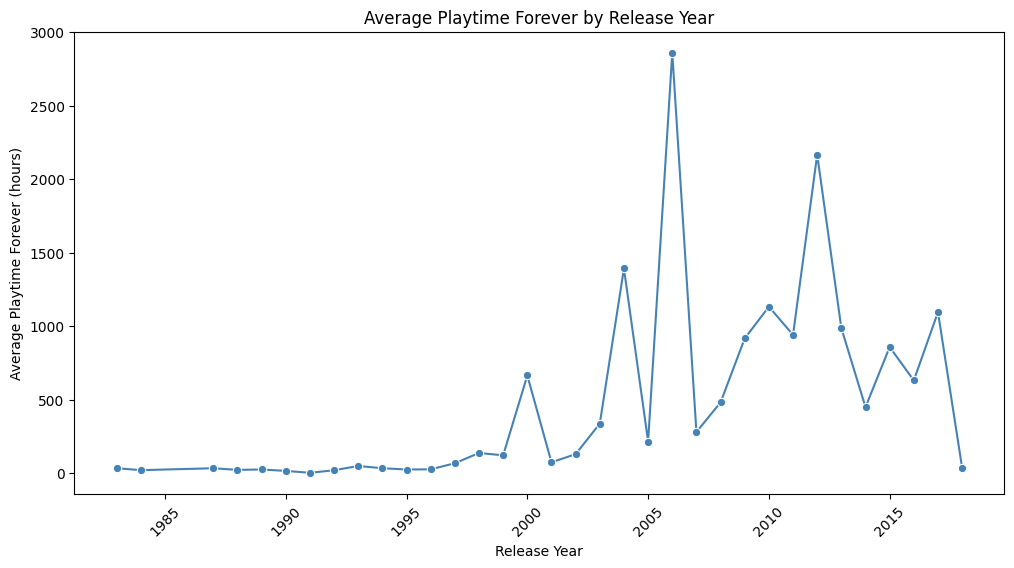

In [ ]:
# extract year
df_merged['release_year'] = pd.to_datetime(df_merged['release_date'], errors='coerce').dt.year

# group by release year and calculate average playtime
avg_playtime_year = df_merged.groupby('release_year')['playtime_forever'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(
    x='release_year',
    y='playtime_forever',
    data=avg_playtime_year,
    marker='o',
    color='steelblue'
)
plt.xlabel("Release Year")
plt.ylabel("Average Playtime Forever (hours)")
plt.title("Average Playtime Forever by Release Year")
plt.xticks(rotation=45)
plt.show()

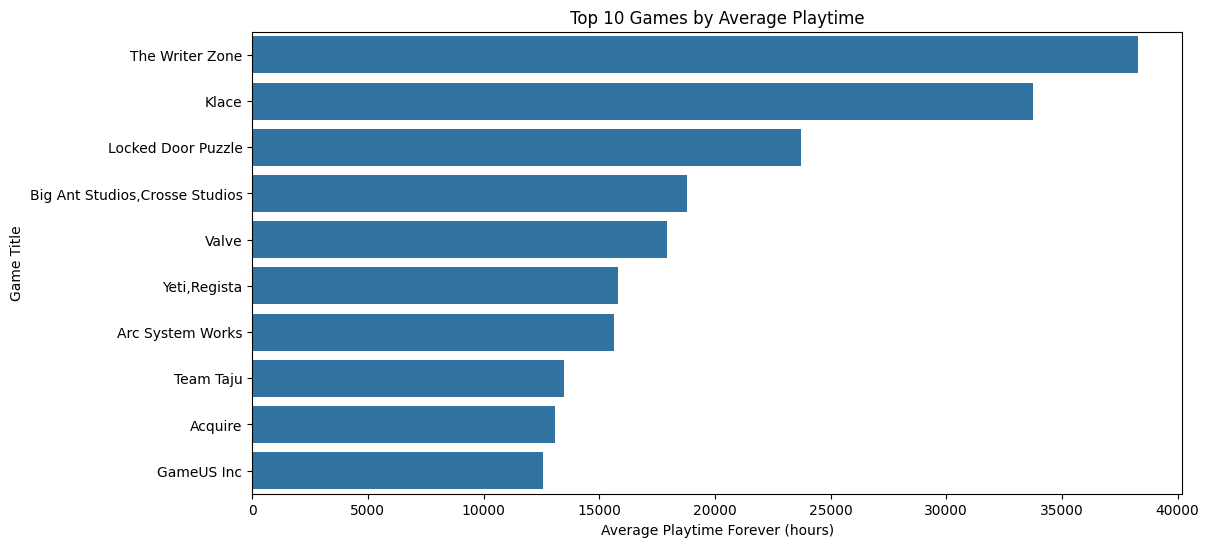

In [ ]:
# average playtime per game
avg_playtime_games = df_merged.groupby('id')['playtime_forever'].mean().reset_index()

avg_playtime_games = avg_playtime_games.merge(
    steam_games[['id','developer']], on='id', how='left'
)

# sort and select top 10
top10_games = avg_playtime_games.sort_values('playtime_forever', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(
    x='playtime_forever',
    y='developer',
    data=top10_games
)
plt.xlabel("Average Playtime Forever (hours)")
plt.ylabel("Game Title")
plt.title("Top 10 Games by Average Playtime")
plt.show()

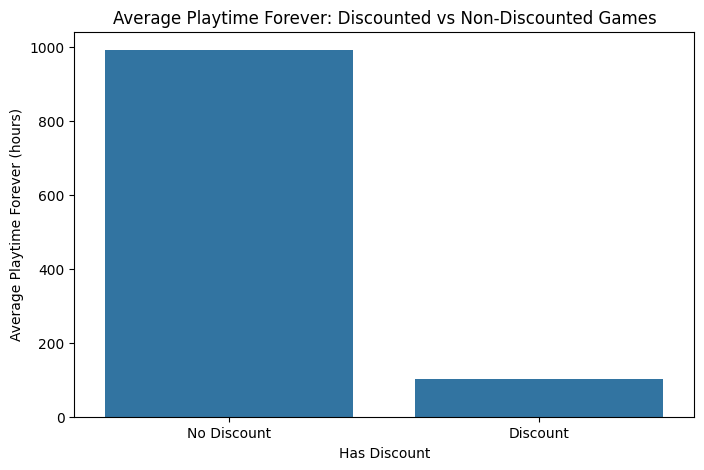

In [ ]:
# flag for discount
df_merged['has_discount'] = df_merged['discount_price'].notna()

# group by discount flag
avg_playtime_discount = df_merged.groupby('has_discount')['playtime_forever'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(
    x='has_discount',
    y='playtime_forever',
    data=avg_playtime_discount
)
plt.xlabel("Has Discount")
plt.ylabel("Average Playtime Forever (hours)")
plt.title("Average Playtime Forever: Discounted vs Non-Discounted Games")
plt.xticks([0,1], ["No Discount", "Discount"])
plt.show()

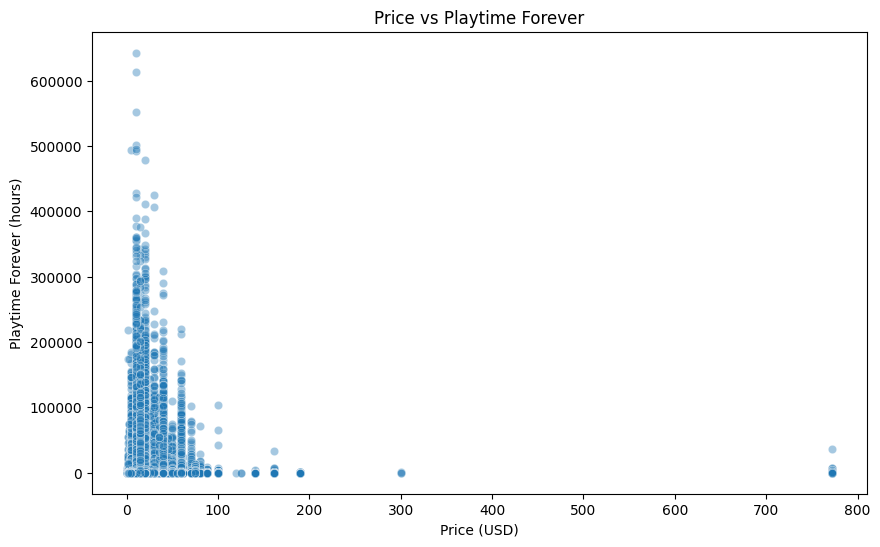

In [ ]:
# Price vs Playtime Forever
df_merged['price_clean'] = pd.to_numeric(df_merged['price'], errors='coerce')

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='price_clean',
    y='playtime_forever',
    data=df_merged,
    alpha=0.4
)
plt.xlabel("Price (USD)")
plt.ylabel("Playtime Forever (hours)")
plt.title("Price vs Playtime Forever")
plt.show()

# Modeling
## Create `item_matrix`

### Cleaning, Imputation, One-Hot Encoding

In [ ]:
item_matrix = steam_games.copy()
item_matrix['tags'] = item_matrix['tags'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['specs'] = item_matrix['specs'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['title'] = item_matrix.apply(lambda x: x['title'] if isinstance(x['title'], str) else x['app_name'], axis=1)

# price cleaning
def clean_price(x):
    if isinstance(x, float):
        return x
    if isinstance(x, str):
        x_lower = x.strip().lower()
        if 'free' in x_lower:
            return 0.0
        try:
            return float(x)
        except ValueError:
            return np.nan
    return np.nan

item_matrix['price'] = item_matrix['price'].apply(clean_price)
item_matrix['price'] = item_matrix['price'].fillna(item_matrix['price'].mean())
item_matrix['discount_price'] = item_matrix['discount_price'].apply(clean_price)
item_matrix['discount_price'] = item_matrix['discount_price'].fillna(item_matrix['price'])
item_matrix['discount_pct'] = (1 - (item_matrix['discount_price'] / (item_matrix['price'] + 0.0001))) * 100
item_matrix['discount_pct'] = item_matrix['discount_pct'].clip(0, 100)
item_matrix['discount_pct'] = item_matrix.apply(lambda x : 0 if x['discount_price'] == x['price'] else x['discount_pct'], axis=1)

# OHE tags
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(item_matrix['tags'])
tag_columns = [f"tag_{c}" for c in mlb.classes_]
df_tags = pd.DataFrame(binary_matrix, columns=tag_columns, index=item_matrix.index)

# OHE specs
mlb_specs = MultiLabelBinarizer()
binary_matrix_specs = mlb_specs.fit_transform(item_matrix['specs'])
spec_columns = [f"spec_{c}" for c in mlb_specs.classes_]
df_specs = pd.DataFrame(binary_matrix_specs, columns=spec_columns, index=item_matrix.index)

keep_cols = ['id', 'title', 'price', 'discount_price', 'discount_pct', 'release_date', 'developer', 'sentiment']
item_matrix = pd.concat([item_matrix[keep_cols], df_tags, df_specs], axis=1)

# Binary developers
top_30 = item_matrix['developer'].value_counts()[:30].index
pattern = '|'.join([str(x) for x in top_30 if len(str(x)) > 0])
item_matrix['top_30_dev'] = item_matrix['developer'].str.contains(pattern, na=False, case=False).astype(int)

item_matrix = item_matrix.drop(columns=['title', 'developer'])
item_matrix['release_date'] = pd.to_datetime(item_matrix['release_date'], errors='coerce')

item_matrix.head()

/var/folders/dh/ryvcfn8s7t35nrc2jw1b335w0000gp/T/ipykernel_6285/2129606587.py:44: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  item_matrix['top_30_dev'] = item_matrix['developer'].str.contains(pattern, na=False, case=False).astype(int)


,id,price,discount_price,discount_pct,release_date,sentiment,tag_1980s,tag_1990's,tag_2.5D,tag_2D,...,spec_Steam Cloud,spec_Steam Leaderboards,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev
0,761140,4.99,4.49,10.021843,2018-01-04,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,0.00,0.00,0.000000,2018-01-04,Mostly Positive,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,670290,0.00,0.00,0.000000,2017-07-24,Mostly Positive,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,0.99,0.83,16.170084,2017-12-07,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,2.99,1.79,40.135781,NaT,NaN,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Sentiment Order Mapping

In [22]:
# Sentiment Mapping
# mapping dictionary:
sentiment_map = {
    'Overwhelmingly Positive': 1,
    'Very Positive': 0.75,
    'Mostly Positive': 0.5,
    'Positive': 0.25,
    'Mixed': 0,
    'Mostly Negative': -0.5,
    'Negative': -0.25,
    'Very Negative': -0.75,
    'Overwhelmingly Negative': -1
}

def get_sentiment_score(s):
    if not isinstance(s, str):
        return 0
    
    if s in sentiment_map:
        return sentiment_map[s]
    
    # 2. Check for "X user reviews" pattern (1-9 reviews)
    if 'user reviews' in s:
        return 0
        
    return np.nan

item_matrix['sentiment_score'] = item_matrix['sentiment'].apply(get_sentiment_score)
mean_score = item_matrix['sentiment_score'].mean()
item_matrix['sentiment_score'] = item_matrix['sentiment_score'].fillna(mean_score)
item_matrix.head()

,id,price,discount_price,discount_pct,release_date,sentiment,tag_1980s,tag_1990's,tag_2.5D,tag_2D,...,spec_Steam Leaderboards,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score
0,761140,4.99,4.49,10.021843,2018-01-04,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,643980,0.00,0.00,0.000000,2018-01-04,Mostly Positive,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0.5
2,670290,0.00,0.00,0.000000,2017-07-24,Mostly Positive,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5
3,767400,0.99,0.83,16.170084,2017-12-07,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,773570,2.99,1.79,40.135781,NaT,NaN,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0


In [23]:
item_matrix[['sentiment', 'sentiment_score']]

,sentiment,sentiment_score
0,NaN,0.00
1,Mostly Positive,0.50
2,Mostly Positive,0.50
3,NaN,0.00
4,NaN,0.00
...,...,...
32128,NaN,0.00
32129,NaN,0.00
32130,NaN,0.00
32131,1 user reviews,0.00


### Convert `release_date` -> `game_age` (years since release)

In [24]:
# Release Date (Convert to Age)
CURRENT_YEAR = 2025

item_matrix['release_date'] = pd.to_datetime(item_matrix['release_date'], errors='coerce')
item_matrix['release_year'] = item_matrix['release_date'].dt.year

# impute nulls with median year
median_year = item_matrix['release_year'].median()
item_matrix['release_year'] = item_matrix['release_year'].fillna(median_year)

# create "Game Age"
item_matrix['game_age'] = CURRENT_YEAR - item_matrix['release_year']

# drop release_date, release_year, sentiment
item_matrix.drop(columns=['release_date', 'release_year'], inplace=True)
if 'sentiment' in item_matrix.columns and 'sentiment_score' in item_matrix.columns:
    item_matrix.drop(columns=['sentiment'], inplace=True)

# rename to item_id
item_matrix = item_matrix.rename(columns={'id': 'item_id'})

In [25]:
item_matrix.head()

,item_id,price,discount_price,discount_pct,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,tag_360 Video,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
0,761140,4.99,4.49,10.021843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,7.0
1,643980,0.00,0.00,0.000000,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0.5,7.0
2,670290,0.00,0.00,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.5,8.0
3,767400,0.99,0.83,16.170084,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,8.0
4,773570,2.99,1.79,40.135781,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.0,9.0


## Create `user_matrix`

### Column Reduction and Binary Encoding for >2h Playtime

In [26]:
user_matrix = australian_users_items.explode('items').reset_index(drop=True)
items_normalized = pd.json_normalize(user_matrix['items'])
user_matrix = pd.concat([user_matrix.drop('items', axis=1), items_normalized], axis=1)

use = user_matrix.copy()
print("Shape:", use.shape)
use.head()

Shape: (5170015, 8)


,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


In [27]:
use["item_id"].isna().value_counts()

item_id
False    5153209
True       16806
Name: count, dtype: int64

In [28]:
use["steam_id"].isna().value_counts()

steam_id
False    5170015
Name: count, dtype: int64

In [29]:
use[use["item_id"].isna()]

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3733,Wackky,0,76561198039117046,http://steamcommunity.com/id/Wackky,NaN,NaN,NaN,NaN
3849,76561198079601835,0,76561198079601835,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN
6019,hellom8o,0,76561198117222320,http://steamcommunity.com/id/hellom8o,NaN,NaN,NaN,NaN
6523,starkillershadow553,0,76561198059648579,http://steamcommunity.com/id/starkillershadow553,NaN,NaN,NaN,NaN
7237,darkenkane,0,76561198058876001,http://steamcommunity.com/id/darkenkane,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5169470,76561198316380182,0,76561198316380182,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169471,76561198316970597,0,76561198316970597,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169472,76561198318100691,0,76561198318100691,http://steamcommunity.com/profiles/76561198318...,NaN,NaN,NaN,NaN
5170006,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,NaN,NaN,NaN,NaN


In [ ]:
user_matrix = user_matrix[['steam_id','item_id','playtime_forever']]
# binary target variable 'y': 1 if playtime_forever >= 120 mins, else 0
user_matrix['y'] = pd.Series(user_matrix['playtime_forever'] >= 120.0).apply(int)
user_matrix = user_matrix[['steam_id','item_id','y']]
# remove rows with missing item_id
user_matrix = user_matrix.dropna(subset=["item_id"])

In [31]:
user_matrix

,steam_id,item_id,y
0,76561197970982479,10,0
1,76561197970982479,20,0
2,76561197970982479,30,0
3,76561197970982479,40,0
4,76561197970982479,50,0
...,...,...,...
5170009,76561198329548331,346330,0
5170010,76561198329548331,373330,0
5170011,76561198329548331,388490,0
5170012,76561198329548331,521570,0


In [32]:
user_matrix['y'].value_counts()

y
0    3187700
1    1965509
Name: count, dtype: int64

## Negative Sampling
### negative sampling to balance the dataset by adding games not bought by users and bought but played less than 2hr

In [ ]:
item_matrix['item_id'] = item_matrix['item_id'].astype(str)
user_matrix['item_id'] = user_matrix['item_id'].astype(str)
user_matrix['steam_id'] = user_matrix['steam_id'].astype(str)

all_game_ids_list = list(item_matrix['item_id'].unique())
n_games = len(all_game_ids_list)
user_owned_dict = user_matrix.groupby('steam_id')['item_id'].apply(set).to_dict()

positives = user_matrix[user_matrix['y'] == 1][['steam_id', 'item_id', 'y']].copy()
hard_negatives = user_matrix[user_matrix['y'] == 0][['steam_id', 'item_id', 'y']].copy()

n_pos = len(positives)
n_hard = len(hard_negatives)

n_soft_target = n_hard 

soft_negative_list = []
user_pool = positives['steam_id'].tolist()

count = 0
while count < n_soft_target:
    u_id = random.choice(user_pool)
    owned_games = user_owned_dict.get(u_id, set())
    
    if len(owned_games) >= n_games:
        continue

    while True:
        rand_idx = random.randint(0, n_games - 1)
        random_game_id = all_game_ids_list[rand_idx]
        
        if random_game_id not in owned_games:
            soft_negative_list.append({'steam_id': u_id, 'item_id': random_game_id, 'y': 0})
            break
    
    count += 1

soft_negatives = pd.DataFrame(soft_negative_list)
negative_pool = pd.concat([hard_negatives, soft_negatives], ignore_index=True)

final_negatives = negative_pool.sample(n=n_pos, random_state=42)


df_training_data = pd.concat([positives, final_negatives], ignore_index=True)
df_training_data = df_training_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
df_training_data['y'].value_counts()

y
0    1965509
1    1965509
Name: count, dtype: int64

## Merge `item_matrix` and `user_matrix`

In [ ]:
target_size = 500_000 

if len(df_training_data) > target_size:
    print(f"Downsampling from {len(df_training_data)} to {target_size} to save RAM...")
    df_training_data_sampled = df_training_data.sample(n=target_size, random_state=42)
else:
    df_training_data_sampled = df_training_data

final_df = df_training_data_sampled.merge(item_matrix, on='item_id', how='left')
final_df.fillna(0, inplace=True)

print("Final Dataset Shape:", final_df.shape)
final_df.head()

Downsampling from 3931018 to 500000 to save RAM...
Final Dataset Shape: (500002, 388)


,steam_id,item_id,y,price,discount_price,discount_pct,tag_1980s,tag_1990's,tag_2.5D,tag_2D,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
0,76561198088043894,312990,1,0.00,0.00,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,11.0
1,76561198043463874,412400,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.00,10.0
2,76561197982951842,13250,0,9.99,9.99,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,27.0
3,76561198060067718,383230,1,12.99,12.99,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,9.0
4,76561198047520506,433850,1,19.99,19.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,9.0


In [36]:
final_df['steam_id'].nunique(), final_df['item_id'].nunique()

(58760, 32817)

In [37]:
final_df.query('steam_id == "76561198053278627"')

,steam_id,item_id,y,price,discount_price,discount_pct,tag_1980s,tag_1990's,tag_2.5D,tag_2D,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
103172,76561198053278627,205950,0,7.990000,7.990000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,13.0
125406,76561198053278627,527080,0,29.990000,29.990000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,9.0
181925,76561198053278627,550,1,19.990000,19.990000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.00,16.0
195031,76561198053278627,35450,1,19.990000,19.990000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.75,14.0
234376,76561198053278627,19900,1,9.990000,9.990000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.50,17.0
280664,76561198053278627,90047,0,8.869015,8.869015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,16.0
291311,76561198053278627,61600,1,4.990000,4.990000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,15.0
309851,76561198053278627,620,1,19.990000,19.990000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,14.0
345813,76561198053278627,282440,1,9.990000,9.990000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75,15.0
365331,76561198053278627,47830,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [38]:
final_df.query('steam_id == "76561198053278627"')['y'].value_counts()

y
1    6
0    5
Name: count, dtype: int64

In [39]:
final_df['y'].value_counts()

y
0    250148
1    249854
Name: count, dtype: int64

## Train/Test Split Preparation

In [ ]:
feature_cols = [c for c in final_df.columns if c not in ['steam_id', 'item_id', 'y']]

train_df, test_df = train_test_split(
    final_df,
    test_size=0.2,
    random_state=42,
    stratify=final_df['y']
)

X_train = train_df[feature_cols]
y_train = train_df['y']
X_test = test_df[feature_cols]
y_test = test_df['y']

# Models
## Baseline Model 1: Sentiment Threshold Model

In [41]:
test_df['y_pred_class'] = (test_df['sentiment_score'] >= 0.5).astype(int)

print(f"Baseline Accuracy: {accuracy_score(test_df['y'], test_df['y_pred_class']):.4f}")
print(f"Baseline F1:       {f1_score(test_df['y'], test_df['y_pred_class']):.4f}")

Baseline Accuracy: 0.6849
Baseline F1:       0.7136


## Baseline Model 2: Popularity Threshold Model

In [42]:
train_positives = train_df[train_df['y'] == 1]
item_counts = train_positives['item_id'].value_counts()

THRESHOLD = 200
popular_items_set = set(item_counts[item_counts > THRESHOLD].index)

test_item_ids = test_df['item_id'].values
test_labels = test_df['y'].values

y_pred_baseline = [1 if item in popular_items_set else 0 for item in test_item_ids]

print(f"Baseline Accuracy: {accuracy_score(test_labels, y_pred_baseline):.4f}")
print(f"Baseline F1:       {f1_score(test_labels, y_pred_baseline):.4f}")
print(f"Baseline AUC:      {roc_auc_score(test_labels, y_pred_baseline):.4f}")

Baseline Accuracy: 0.7460
Baseline F1:       0.7049
Baseline AUC:      0.7459


## Model 1: Logistic Regression

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(f"LogReg Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"LogReg F1:       {f1_score(y_test, y_pred_lr):.4f}")
print(f"LogReg AUC:      {roc_auc_score(y_test, y_prob_lr):.4f}")

LogReg Accuracy: 0.7727
LogReg F1:       0.7933
LogReg AUC:      0.8577


## Model 2: XGBoost

In [44]:
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=6, 
    n_jobs=-1, 
    random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost F1:       {f1_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost AUC:      {roc_auc_score(y_test, y_prob_xgb):.4f}")

XGBoost Accuracy: 0.7908
XGBoost F1:       0.8085
XGBoost AUC:      0.8809


## Model 3: Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=250,   
    max_depth=6,        
    n_jobs=-1,          
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest F1:       {f1_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest AUC:      {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest Accuracy: 0.7587
Random Forest F1:       0.7639
Random Forest AUC:      0.8501


# Evaluations
## Model Performance Comparison

| **Model** | **Accuracy** | **F1 Score** | **AUC** |
|-----------|--------------|--------------|---------|
| **Baseline 1: Sentiment Threshold** | 0.6849 | 0.7136 | — |
| **Baseline 2: Popularity Threshold** | 0.7460 | 0.7049 | 0.7459 |
| **Logistic Regression** | 0.7727 | 0.7933 | 0.8577 |
| **XGBoost** | **0.7908** | **0.8085** | **0.8809** |
| **Random Forest** | 0.7587 | 0.7639 | 0.8501 |

## Visualization

                             Feature  Importance
346        spec_Downloadable Content    0.167693
383                  sentiment_score    0.055845
203                   tag_Open World    0.044359
61                         tag_Co-op    0.037394
186                  tag_Multiplayer    0.036518
264                 tag_Singleplayer    0.028869
1                     discount_price    0.026326
202                 tag_Online Co-Op    0.023372
241                 tag_Replay Value    0.021011
252                      tag_Sandbox    0.013557
375         spec_Steam Trading Cards    0.013135
357                         spec_MMO    0.013033
229                          tag_PvP    0.012721
384                         game_age    0.012049
379  spec_Tracked Motion Controllers    0.010182


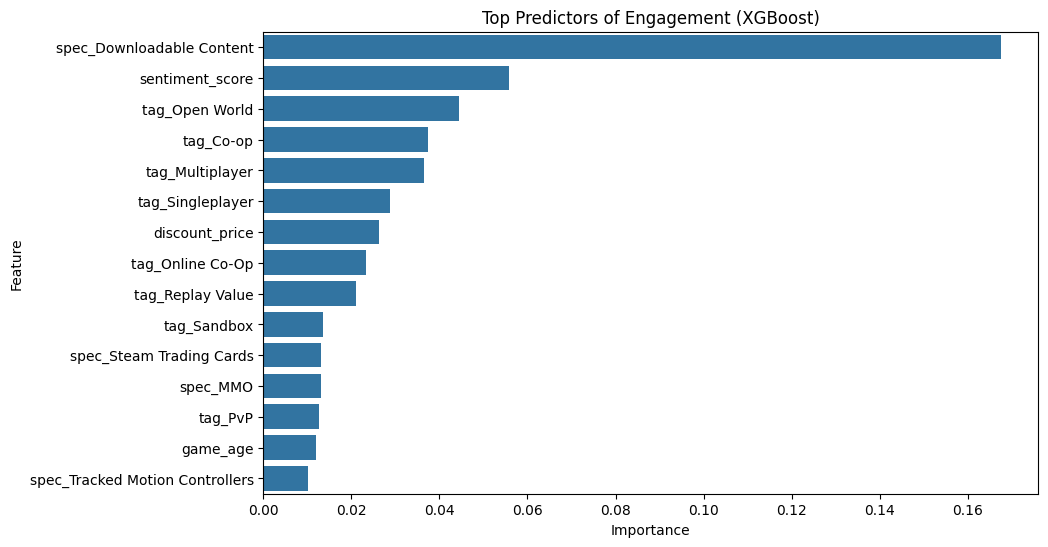

In [ ]:
# XGB top 15 features
imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
top_imp = imp.sort_values(by='Importance', ascending=False).head(15)
print(top_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_imp)
plt.title('Top Predictors of Engagement (XGBoost)')
plt.show()

                       Feature  Importance
383            sentiment_score    0.087645
264           tag_Singleplayer    0.080524
186            tag_Multiplayer    0.072191
61                   tag_Co-op    0.063486
346  spec_Downloadable Content    0.059589
0                        price    0.049894
1               discount_price    0.047484
384                   game_age    0.047163
202           tag_Online Co-Op    0.037076
30             tag_Atmospheric    0.023325
203             tag_Open World    0.021651
252                tag_Sandbox    0.020322
105                    tag_FPS    0.019597
259                tag_Shooter    0.017624
15                  tag_Action    0.017359


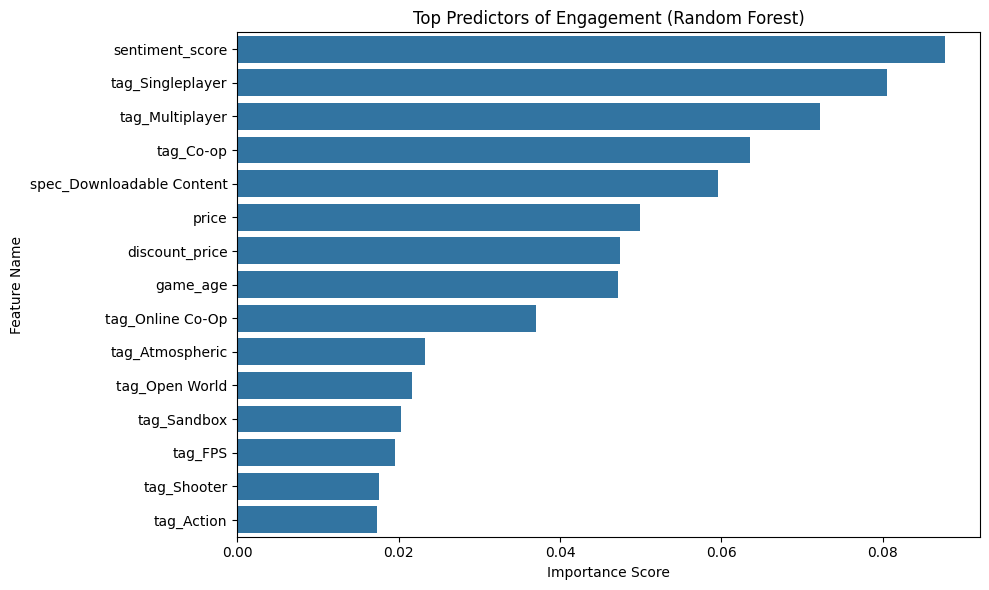

In [ ]:
# RF Feature Importance
rf_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})
top_rf_imp = rf_imp.sort_values(by='Importance', ascending=False).head(15)
print(top_rf_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_rf_imp)
plt.title('Top Predictors of Engagement (Random Forest)')
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# Recommendation Engine

In [ ]:
def recommend_games(user_id, model, item_matrix, top_k=10):
    """
    1. Identify games the user already owns (to exclude them).
    2. Select a pool of Candidate Games (e.g., 100 random unowned games).
    3. Construct the Feature Vector for these candidates.
    4. Ask the Model to predict the probability of playing.
    5. Return the Top K games with the highest probability.
    """
    
    try:
        user_history = set(user_matrix[user_matrix['steam_id'] == user_id]['item_id'])
    except:
        user_history = set()
    
    # pick 100 random games the user doesn't own.
    item_matrix['item_id'] = item_matrix['item_id'].astype(int)
    all_items = set(item_matrix['item_id'])
    candidates = list(all_items - user_history)
    
    if len(candidates) > 100:
        candidates = random.sample(candidates, 100)
    
    # Prediction df
    # metadata for these candidates from item_matrix
    candidate_df = item_matrix[item_matrix['item_id'].isin(candidates)].copy()

    X_pred = candidate_df.drop(columns=['item_id'], errors='ignore')
    X_pred = X_pred.select_dtypes(include=[np.number])
    
    # Score Candidates
    # predict_proba to get the specific % chance (like 0.85)
    probs = model.predict_proba(X_pred)[:, 1]
    
    # Rank
    candidate_df['probability'] = probs
    recommendations = candidate_df.sort_values(by='probability', ascending=False).head(top_k)
    
    # return recommendations[['item_id', 'probability', 'popularity_log', 'price']]
    return recommendations[['item_id', 'probability', 'price']]

### Demo

In [ ]:
# RECOMMEND FOR A RANDOM USER

random_user = user_matrix['steam_id'].sample(1).values[0]

print(f"Generating Recommendations for User: {random_user}")
recs = recommend_games(random_user, xgb, item_matrix)

steam_games['id'] = steam_games['id'].astype(int)
recs_readable = recs.merge(steam_games[['id', 'app_name']], left_on='item_id', right_on='id', how='left')

print("\nTop 10 Recommended Games:")
print(recs_readable[['app_name', 'probability', 'price']])

Generating Recommendations for User: 76561198092411867

Top 10 Recommended Games:
                                            app_name  probability  price
0                                       Just Cause 2     0.808920  14.99
1  The Witcher 2: Assassins of Kings Enhanced Edi...     0.741304  19.99
2                                 Tales of Symphonia     0.691323  19.99
3                         Westerado: Double Barreled     0.582998  14.99
4                                         4 Elements     0.518355   3.99
5                                     Spaceport Hope     0.503001   1.99
6                               World of Tanks Blitz     0.406073   0.00
7                                       Moonbase 332     0.352440   4.99
8                                          Harvester     0.321068   5.99
9                                           Gunslugs     0.279195   4.99


In [50]:
user_matrix['item_id'] = user_matrix['item_id'].astype(str)
steam_games['id'] = steam_games['id'].astype(str)
merged_df = user_matrix[user_matrix['steam_id'] == random_user].merge(
    right=steam_games[["id", "app_name", "title"]], 
    left_on="item_id", 
    right_on="id", 
    how="left"
)

merged_df = merged_df.drop(columns=['id'])

merged_df.sample(10).sort_values(by = "y")

,steam_id,item_id,y,app_name,title
14,76561198092411867,328060,0,Tales Runner,Tales Runner
18,76561198092411867,424280,0,Iron Snout,Iron Snout
16,76561198092411867,349700,0,Romero's Aftermath,Romero's Aftermath
17,76561198092411867,381210,1,NaN,NaN
7,76561198092411867,206420,1,Saints Row IV,Saints Row IV
15,76561198092411867,339610,1,Freestyle 2: Street Basketball,Freestyle 2: Street Basketball
11,76561198092411867,304050,1,Trove,Trove
13,76561198092411867,227700,1,NaN,NaN
9,76561198092411867,301520,1,Robocraft,Robocraft
19,76561198092411867,273350,1,Evolve Stage 2,Evolve Stage 2


In [51]:
def show_recommendations_with_images(recs_df):
    """
    Takes the recommendation dataframe and renders an HTML table 
    with game box art using Steam's public CDN.
    """
    html = "<h3>Top 10 Personalized Recommendations</h3>"
    html += "<table style='width:100%; text-align:left;'>"
    html += "<tr><th>Image</th><th>Game Title</th><th>Confidence</th><th>Price</th></tr>"
    
    for _, row in recs_df.iterrows():
        app_id = row['item_id']
        name = row['app_name']
        prob = row['probability']
        price = row['price']
        
        # Steam Header Image URL Pattern
        img_url = f"https://cdn.akamai.steamstatic.com/steam/apps/{app_id}/header.jpg"
        
        # formatting
        prob_color = "green" if prob > 0.8 else "orange" if prob > 0.5 else "red"
        
        html += f"""
        <tr>
            <td style='width:150px'><img src='{img_url}' style='width:120px; border-radius:5px;'></td>
            <td style='font-weight:bold; font-size:14px'>{name}</td>
            <td style='color:{prob_color}; font-weight:bold'>{prob:.1%}</td>
            <td>${price}</td>
        </tr>
        """
    html += "</table>"
    display(HTML(html))

# Run it on your results
# Make sure your recs_readable has 'item_id' (it might have been lost in merge or named 'id')
recs_readable['item_id'] = recs_readable['id'] # Ensure ID is there
show_recommendations_with_images(recs_readable)

Image,Game Title,Confidence,Price
,Just Cause 2,80.9%,$14.99
,The Witcher 2: Assassins of Kings Enhanced Edition,74.1%,$19.99
,Tales of Symphonia,69.1%,$19.99
,Westerado: Double Barreled,58.3%,$14.99
,4 Elements,51.8%,$3.99
,Spaceport Hope,50.3%,$1.99
,World of Tanks Blitz,40.6%,$0.0
,Moonbase 332,35.2%,$4.99
,Harvester,32.1%,$5.99
,Gunslugs,27.9%,$4.99
